In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
sns.set_theme(style="whitegrid")

## Movies Metadata

### **Data description**

| Column name          | Description                                                                                                                                                                                       |   |   |   |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |   |   |   |
| freebase_movie_id| ID of the movie from freebas                                                                                                                                            |   |   |   |
| movie_name | Name of the movie                                                                                                                                                |   |   |   |
| movie_release_date  | Date the movie was released                                                                                                                                      |   |   |   |
| movie_box_office_revenue  | Revenue of the movie box office                                                                                                                           
| movie_runtime  | Run time of the movie                                                                                                                                                 |   |   |   |
| movie_languages | Languages of the movie                                                                                                                                                  |   |   |   |
| movie_countries | Countries where the movie were created                                                                                                                                  |   |   |   |
| movie_genres   | Genre of the movie                                                                                                                                              |   |   |   |

The movie data set contains 81741 rows.



In [57]:
data_folder = './data/'

names = ['wikipedia_movie_id','freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 
        'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

movies_data = pd.read_csv(data_folder + 'movie.metadata.tsv', names = names, sep = '\t', )

movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']]= movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda x: str.lower(x))

movies_data.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograp..."
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""norwegian language""}","{""/m/05b4w"": ""norway""}","{""/m/0lsxr"": ""crime fiction"", ""/m/07s9rl0"": ""d..."
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""english language""}","{""/m/07ssc"": ""united kingdom""}","{""/m/01jfsb"": ""thriller"", ""/m/0glj9q"": ""erotic..."
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""german language""}","{""/m/0345h"": ""germany""}","{""/m/07s9rl0"": ""drama""}"


In [58]:
#rating files loading
ratings = pd.read_csv(data_folder + 'title.ratings.tsv.gz', sep='\t', compression='gzip')
titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')

rates = ratings.merge(titles, how='left', on='tconst')[['averageRating', 'numVotes', 'originalTitle']]
rates['movie_name'] = [ele.lower() for ele in rates['originalTitle'].astype(str)]
rates=rates.drop(columns='originalTitle')
rates = rates.drop_duplicates('movie_name')

C:\Users\hugom\AppData\Local\Temp\ipykernel_11300\1916311161.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')


In [59]:
movies_data.shape

(81741, 9)

In [60]:
indian_movies = movies_data[movies_data['movie_countries'] == '{"/m/03rk0": "india"}']
american_movies = movies_data[movies_data['movie_countries'] == '{"/m/09c7w0": "united states of america"}']

indian_movies = indian_movies.merge(rates, how = 'left', on='movie_name')
american_movies = american_movies.merge(rates, how = 'left', on='movie_name')

print(len(indian_movies), len(american_movies))

8240 30300


In [61]:
print('%.3f percent of indian movies have a rating and %.3f percent of american movies have a rating' %
(100-np.sum(indian_movies['averageRating'].isna())/indian_movies.shape[0]*100, 100-np.sum(american_movies['averageRating'].isna())/american_movies.shape[0]*100))

print('Average rating of indian movies : %.3f \tAverage rating of american movies : %.3f' %
(np.mean(indian_movies['averageRating']), np.mean(american_movies['averageRating'])))

72.633 percent of indian movies have a rating and 88.017 percent of american movies have a rating
Average rating of indian movies : 6.358 	Average rating of american movies : 6.159


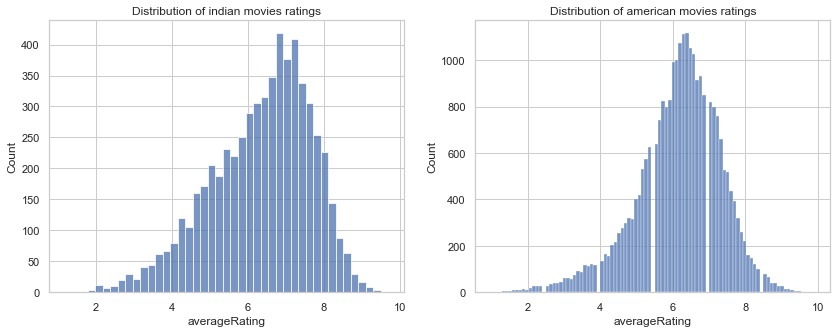

In [62]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(x='averageRating', data=indian_movies)
plt.title('Distribution of indian movies ratings')
plt.subplot(1,2,2)
sns.histplot(x='averageRating', data=american_movies)
plt.title('Distribution of american movies ratings')
plt.show()

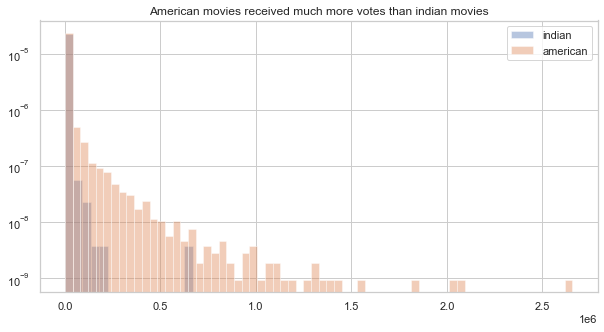

In [63]:
fac = (len(indian_movies)-np.sum(indian_movies['averageRating'].isna()))/(len(american_movies)-np.sum(american_movies['averageRating'].isna()))
plt.figure(figsize=(10,5))
plt.hist(indian_movies['numVotes'], density=True, bins = 15, alpha=.4, label='indian')
plt.hist(american_movies['numVotes'], density=True, bins = int(15/fac), alpha = 0.4, label='american')
plt.yscale('log')
plt.title('American movies received much more votes than indian movies')
plt.legend()
plt.show()

In [64]:
print('P-value for normality test of american movies : %.3f \tP-value for normality test of indian movies : %.3f ' 
      % (st.normaltest(american_movies['averageRating'], nan_policy='omit').pvalue, st.normaltest(indian_movies['averageRating'], nan_policy='omit').pvalue))

P-value for normality test of american movies : 0.000 	P-value for normality test of indian movies : 0.000 


In [65]:
#center data on mean
indian_movies['centeredRating']=indian_movies['averageRating']-np.mean(indian_movies['averageRating'])
american_movies['centeredRating']=american_movies['averageRating']-np.mean(american_movies['averageRating'])
print('Centered average rating of indian movies : %.3f \tCentered average rating of american movies : %.3f' %
(np.mean(indian_movies['centeredRating']), np.mean(american_movies['centeredRating'])))

Centered average rating of indian movies : -0.000 	Centered average rating of american movies : -0.000


In [66]:
indian_movies.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,centeredRating
0,20604092,/m/0523t_1,anbu thozhi,2007-08-17,NaN,NaN,"{""/m/07c9s"": ""tamil language""}","{""/m/03rk0"": ""india""}","{""/m/02l7c8"": ""romance film""}",NaN,NaN,NaN
1,11448183,/m/02rc_h4,bindiya chamkegi,1984-01-20,NaN,NaN,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/0hqxf"": ""family film"", ""/m/01z4y"": ""comedy""}",5.1,22.0,-1.257694
2,9633533,/m/02pml15,vandanam,1989,NaN,168.0,"{""/m/0999q"": ""malayalam language""}","{""/m/03rk0"": ""india""}","{""/m/02kdv5l"": ""action""}",7.9,1197.0,1.542306
3,29528534,/m/04j0lfk,anokha rishta,1986,NaN,180.0,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/03q4nz"": ""world cinema"", ""/m/04t36"": ""mus...",7.3,57.0,0.942306
4,29772142,/m/0fq260_,karayilekku oru kadal dooram,2010-12-31,NaN,110.0,"{""/m/0999q"": ""malayalam language""}","{""/m/03rk0"": ""india""}","{""/m/07s9rl0"": ""drama""}",6.6,15.0,0.242306


## Movie Genre


In [67]:
test_indian = indian_movies.copy()
#remove {}
test_indian['cleared_movie_genres'] = test_indian['movie_genres'].str[1:-1]
#remove films without genre
test_indian = test_indian.query("cleared_movie_genres != ''")

test_indian.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,centeredRating,cleared_movie_genres
0,20604092,/m/0523t_1,anbu thozhi,2007-08-17,NaN,NaN,"{""/m/07c9s"": ""tamil language""}","{""/m/03rk0"": ""india""}","{""/m/02l7c8"": ""romance film""}",NaN,NaN,NaN,"""/m/02l7c8"": ""romance film"""
1,11448183,/m/02rc_h4,bindiya chamkegi,1984-01-20,NaN,NaN,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/0hqxf"": ""family film"", ""/m/01z4y"": ""comedy""}",5.1,22.0,-1.257694,"""/m/0hqxf"": ""family film"", ""/m/01z4y"": ""comedy"""
2,9633533,/m/02pml15,vandanam,1989,NaN,168.0,"{""/m/0999q"": ""malayalam language""}","{""/m/03rk0"": ""india""}","{""/m/02kdv5l"": ""action""}",7.9,1197.0,1.542306,"""/m/02kdv5l"": ""action"""
3,29528534,/m/04j0lfk,anokha rishta,1986,NaN,180.0,"{""/m/03k50"": ""hindi language""}","{""/m/03rk0"": ""india""}","{""/m/03q4nz"": ""world cinema"", ""/m/04t36"": ""mus...",7.3,57.0,0.942306,"""/m/03q4nz"": ""world cinema"", ""/m/04t36"": ""musi..."
4,29772142,/m/0fq260_,karayilekku oru kadal dooram,2010-12-31,NaN,110.0,"{""/m/0999q"": ""malayalam language""}","{""/m/03rk0"": ""india""}","{""/m/07s9rl0"": ""drama""}",6.6,15.0,0.242306,"""/m/07s9rl0"": ""drama"""


In [103]:
#create list with all genres
all_genres_listed_indian = test_indian['cleared_movie_genres'].str.split(pat=",")
#all_genres_listed_indian=[ele[0].split(':') for ele in all_genres_listed_indian]
ls = []
for i in all_genres_listed_indian:
    ls.extend(i)
 
all_genres_indian = pd.Series(ls)
all_genres_indian = all_genres_indian.str.strip().value_counts()
all_genres_indian.index = [ele.split(':')[1] for ele in all_genres_indian.index]

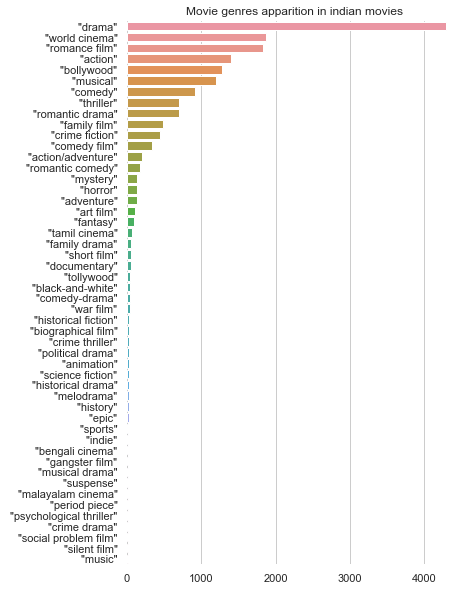

In [104]:
#ploting taking the first 50 genres
first_genres_indian = all_genres_indian[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_indian.index, x = first_genres_indian).set_title('Movie genres apparition in indian movies')
sns.despine(left=True, bottom=True)

In [70]:
test_american = american_movies.copy()
#remove {}
test_american['cleared_movie_genres'] = test_american['movie_genres'].str[1:-1]
#remove films without genre
test_american = test_american.query("cleared_movie_genres != ''")
test_american.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,centeredRating,cleared_movie_genres
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science...",4.9,55210.0,-1.258941,"""/m/01jfsb"": ""thriller"", ""/m/06n90"": ""science ..."
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograp...",NaN,NaN,NaN,"""/m/02n4kr"": ""mystery"", ""/m/03bxz7"": ""biograph..."
2,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""silent film"", ""/m/02h40lc"": ""eng...","{""/m/09c7w0"": ""united states of america""}","{""/m/02hmvc"": ""short film"", ""/m/06ppq"": ""silen...",6.8,16.0,0.641059,"""/m/02hmvc"": ""short film"", ""/m/06ppq"": ""silent..."
3,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/04t36"": ""musical"", ""/m/01z4y"": ""comedy"", ...",3.8,20.0,-2.358941,"""/m/04t36"": ""musical"", ""/m/01z4y"": ""comedy"", ""..."
4,175026,/m/017n1p,sarah and son,1930,NaN,86.0,"{""/m/02h40lc"": ""english language""}","{""/m/09c7w0"": ""united states of america""}","{""/m/07s9rl0"": ""drama"", ""/m/01g6gs"": ""black-an...",5.4,271.0,-0.758941,"""/m/07s9rl0"": ""drama"", ""/m/01g6gs"": ""black-and..."


In [97]:
#create list with all genres
all_genres_listed_american = test_american['cleared_movie_genres'].str.split(pat=",")
#all_genres_listed_american=[ele[0].split(':') for ele in all_genres_listed_american]

ls = []
for i in all_genres_listed_american:
    ls.extend(i)
 
all_genres_american = pd.Series(ls)
all_genres_american = all_genres_american.str.strip().value_counts()
all_genres_american.index=[ele.split(':')[1] for ele in all_genres_american.index]

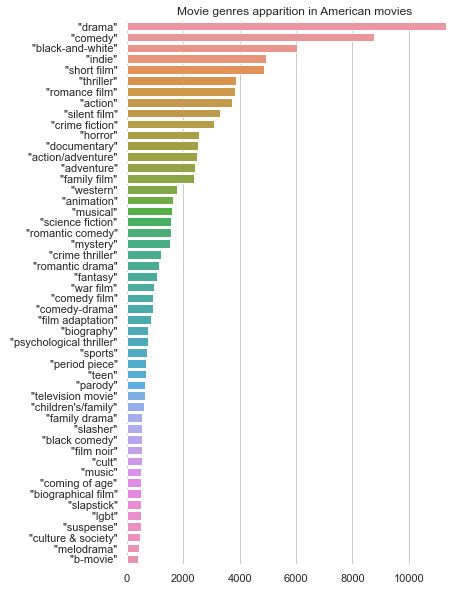

In [98]:
#ploting taking the first 50 genres
first_genres_american = all_genres_american[:50]

f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_american.index, x = first_genres_american).set_title('Movie genres apparition in American movies')
sns.despine(left=True, bottom=True)

In [107]:
all_genres_american_frequency = all_genres_american/len(american_movies)
first_genres_american_frequency = all_genres_american_frequency[:50]
all_genres_indian_frequency = all_genres_indian/len(indian_movies)
first_genres_indian_frequency = all_genres_indian_frequency[:50]

<AxesSubplot:title={'center':'India'}>

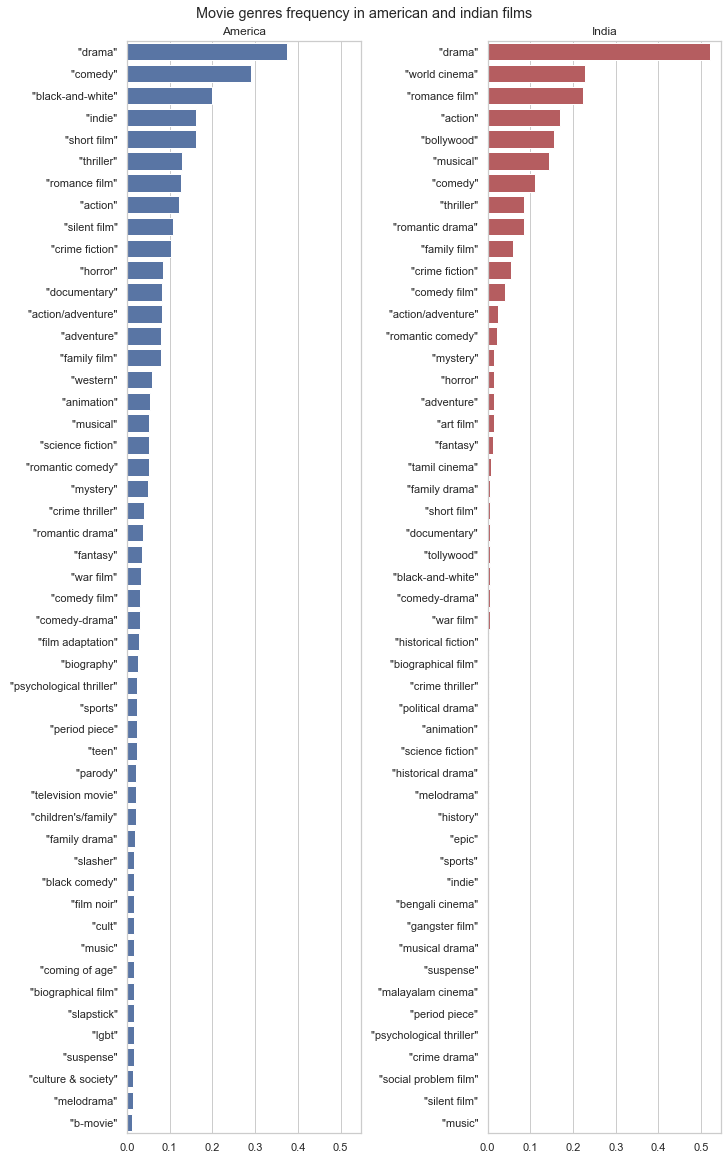

In [108]:
#ploting taking the first 50 genres
fig, ax = plt.subplots(1,2,figsize=(10, 16),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in american and indian films')
ax[0].set_title('America')
ax[1].set_title('India')
sns.barplot(ax = ax[0],y = first_genres_american_frequency.index, x = first_genres_american_frequency, label="American", color="b")

sns.barplot(ax = ax[1], y = first_genres_indian_frequency.index, x = first_genres_indian_frequency, label="Indian", color="r")


### Missing values

We can already see that movie_box_office_revenue column contain loads of missing data in both indian and american movies, followed by movie runtime.

In [109]:
indian_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8240 entries, 0 to 8239
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        8240 non-null   int64  
 1   freebase_movie_id         8240 non-null   object 
 2   movie_name                8240 non-null   object 
 3   movie_release_date        7599 non-null   object 
 4   movie_box_office_revenue  27 non-null     float64
 5   movie_runtime             3558 non-null   float64
 6   movie_languages           8240 non-null   object 
 7   movie_countries           8240 non-null   object 
 8   movie_genres              8240 non-null   object 
 9   averageRating             5985 non-null   float64
 10  numVotes                  5985 non-null   float64
 11  centeredRating            5985 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 836.9+ KB


### Cleaning data 

Our indian and american movies data base both do not contain any duplicates on either wikipedia movie ID nor freebase ID.

In [76]:
print('wiki ID, indian: ', len(indian_movies.drop_duplicates('wikipedia_movie_id')), '\nfreebase ID, indian: ', len(indian_movies.drop_duplicates('freebase_movie_id')))
print('wiki ID, american: ', len(american_movies.drop_duplicates('wikipedia_movie_id')), '\nfreebase ID, american: ', len(american_movies.drop_duplicates('freebase_movie_id')))

wiki ID, indian:  8240 
freebase ID, indian:  8240
wiki ID, american:  30300 
freebase ID, american:  30300


## Characters data

450'668 characters in raw data

134079 differents actor 

5794 differents actor in indian movies

59398 differents actors in american movies


In [77]:
names = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'char_act_id', 'freebase_character_id', 'freebase_actor_id']
characters_data = pd.read_csv(data_folder + 'character.metadata.tsv', names = names, sep = '\t')

characters_data.head(10)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,char_act_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [78]:
characters_data[['character_name', 'actor_name']] = characters_data[['character_name', 'actor_name']].applymap(lambda x: x if type(x)!=str else x.lower())

In [79]:
characters_data.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,char_act_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,akooshay,1958-08-26,F,1.620,NaN,wanda de jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,lieutenant melanie ballard,1974-08-15,F,1.780,/m/044038p,natasha henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,desolation williams,1969-06-15,M,1.727,/m/0x67,ice cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,sgt jericho butler,1967-09-12,M,1.750,NaN,jason statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,bashira kincaid,1977-09-25,F,1.650,NaN,clea duvall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [80]:
unique_american_actor = characters_data[characters_data['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])].drop_duplicates('actor_name')
unique_indian_actor = characters_data[characters_data['wikipedia_movie_id'].isin(indian_movies['wikipedia_movie_id'])].drop_duplicates('actor_name')

In [81]:
unique_american_actor.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,char_act_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,akooshay,1958-08-26,F,1.620,NaN,wanda de jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,lieutenant melanie ballard,1974-08-15,F,1.780,/m/044038p,natasha henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,desolation williams,1969-06-15,M,1.727,/m/0x67,ice cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,sgt jericho butler,1967-09-12,M,1.750,NaN,jason statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,bashira kincaid,1977-09-25,F,1.650,NaN,clea duvall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [82]:
american_character =characters_data[characters_data['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]
american_character =characters_data[characters_data['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]

## Name clusters data

In [83]:
names = ['character_name', 'actor_reference']
name_clusters_data = pd.read_csv(data_folder + 'name.clusters.txt', names = names, sep = '\t', )

name_clusters_data.head(10)

,character_name,actor_reference
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
5,Josh Framm,/m/0jt3p3
6,Josh Framm,/m/0jt3t3
7,Caspian X,/m/0646flc
8,Caspian X,/m/02vd12n
9,Apostle Peter,/m/02vd6_v


## **Tvtropes clusters data**

In [84]:
tvt_rope = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', names= ['character_type', 'instances'])

print(len(tvt_rope))
tvt_rope

501


,character_type,instances
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
...,...,...
496,young_gun,"{""char"": ""Morgan Earp"", ""movie"": ""Tombstone"", ..."
497,young_gun,"{""char"": ""Colorado Ryan"", ""movie"": ""Rio Bravo""..."
498,young_gun,"{""char"": ""Tom Sawyer"", ""movie"": ""The League of..."
499,young_gun,"{""char"": ""William H. 'Billy the Kid' Bonney"", ..."


### Formatting data

In [85]:
tvt_rope['instances'] = tvt_rope['instances'].str.replace('{','').str.replace('}', '').str.replace('"', '')

split_tvt = tvt_rope.copy()

split_tvt = tvt_rope['instances'].str.split('[,:]', expand=True)

cleaned_tvt = split_tvt.rename(columns={split_tvt.columns[1]: 'character_name', split_tvt.columns[3]: 'movie_name', split_tvt.columns[5]: 'char_act_id',split_tvt.columns[7]: 'actor_name'})

cleaned_tvt = cleaned_tvt.drop(columns=[0,2,4,6,8,9,10])

characters = tvt_rope.character_type

final_tvt = cleaned_tvt.join(characters, how= 'left')

final_tvt[['character_name', 'movie_name', 'actor_name', 'character_type']] = final_tvt[['character_name', 'movie_name', 'actor_name', 'character_type']].applymap(lambda x: str.casefold(x))

final_tvt.head()

C:\Users\hugom\AppData\Local\Temp\ipykernel_11300\3016461785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tvt_rope['instances'] = tvt_rope['instances'].str.replace('{','').str.replace('}', '').str.replace('"', '')


,character_name,movie_name,char_act_id,actor_name,character_type
0,professor philip brainard,flubber,/m/0jy9q0,robin williams,absent_minded_professor
1,professor keenbean,richie rich,/m/02vchl3,michael mcshane,absent_minded_professor
2,dr. reinhardt lane,the shadow,/m/0k6fkc,ian mckellen,absent_minded_professor
3,dr. harold medford,them!,/m/0k6_br,edmund gwenn,absent_minded_professor
4,daniel jackson,stargate,/m/0k3rhh,james spader,absent_minded_professor


In [86]:
american_actors = unique_american_actor.copy()
american_actors['actor_name'] = unique_american_actor['actor_name'].astype('str')

american_actors = american_actors['actor_name']

final_tvt.actor_name = final_tvt.actor_name.dropna()

american_tvt = final_tvt.merge(american_actors, on = 'actor_name')

american_tvt

,character_name,movie_name,char_act_id,actor_name,character_type


In [87]:
american_tvt2 = final_tvt[final_tvt['actor_name'].isin(unique_american_actor['actor_name'])]

american_tvt2

,character_name,movie_name,char_act_id,actor_name,character_type


In [88]:
american_tvt2 = final_tvt[final_tvt['movie_name'].isin(american_movies['movie_name'])]

american_tvt2

,character_name,movie_name,char_act_id,actor_name,character_type


## Summaries data

In [89]:
summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\r', names = ['summaries'])
summaries = summaries['summaries'].str.split("\t", expand = True)
summaries = summaries.rename(columns= {0:'wikipedia_movie_id',1: 'summaries'})
summaries['summaries'] = summaries['summaries'].str.lower()
summaries['wikipedia_movie_id'] = summaries['wikipedia_movie_id'].astype(int)
summaries.head(10)

,wikipedia_movie_id,summaries
0,23890098,"shlykov, a hard-working taxi driver and lyosha..."
1,31186339,the nation of panem consists of a wealthy capi...
2,20663735,poovalli induchoodan is sentenced for six yea...
3,2231378,"the lemon drop kid , a new york city swindler,..."
4,595909,seventh-day adventist church pastor michael ch...
5,5272176,the president is on his way to give a speech. ...
6,1952976,"{{plot}} the film opens in 1974, as a young gi..."
7,24225279,"the story begins with hannah, a young jewish t..."
8,2462689,infuriated at being told to write one final co...
9,20532852,a line of people drool at the window of the s...


In [90]:
indian_summaries = summaries[summaries['wikipedia_movie_id'].isin(indian_movies['wikipedia_movie_id'])]
indian_summaries

,wikipedia_movie_id,summaries
2,20663735,poovalli induchoodan is sentenced for six yea...
25,8388648,the film opens with madhav and sreenu playin...
26,10644072,a villager new to the big city – bhagwaan – t...
29,2254491,"preetam , a struggling cartoonist, meets anita..."
45,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
...,...,...
42280,24327307,this mythological film features the antics of ...
42283,22762373,"sakthi is a spoiled rich kid, with his mother ..."
42288,8605430,the story develops around the evolution of tit...
42301,34808485,"the story is about reema , a young muslim scho..."


In [91]:
american_summaries = summaries[summaries['wikipedia_movie_id'].isin(american_movies['wikipedia_movie_id'])]
american_summaries

,wikipedia_movie_id,summaries
1,31186339,the nation of panem consists of a wealthy capi...
3,2231378,"the lemon drop kid , a new york city swindler,..."
6,1952976,"{{plot}} the film opens in 1974, as a young gi..."
7,24225279,"the story begins with hannah, a young jewish t..."
8,2462689,infuriated at being told to write one final co...
...,...,...
42295,26261438,while drinking alone one night and reminiscing...
42297,17208834,a high school prom in georgia is unexpectedly ...
42300,2867597,"an attempt to bring the famed ""mr. bill"" clay ..."
42302,1096473,"in 1928 hollywood, director leo andreyev look..."


In [92]:
indian_separated_words = indian_summaries['summaries'].str.split()

ls = []
 
for i in indian_separated_words:
    ls.extend(i)

indian_separated_words = pd.Series(ls)
indian_separated_words = indian_separated_words[indian_separated_words.str.len() > 4]
indian_separated_words = indian_separated_words.value_counts()

<AxesSubplot:>

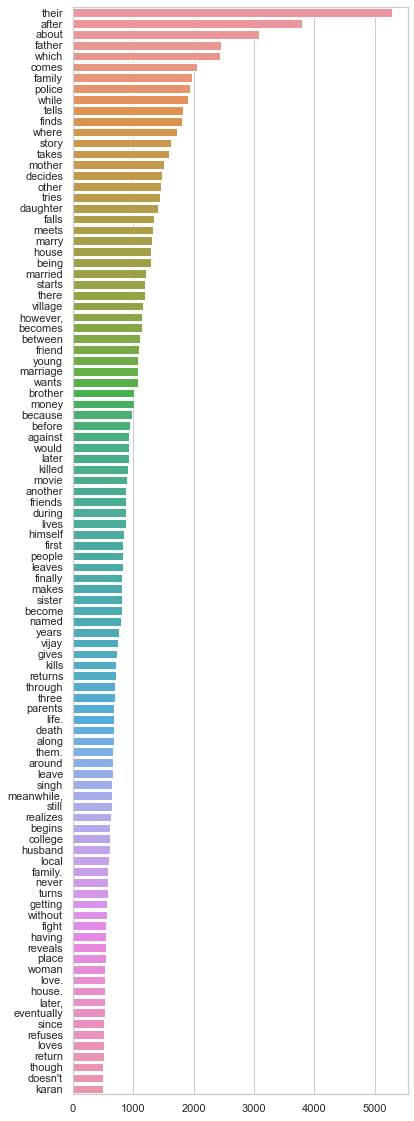

In [93]:
indian_separated_words = indian_separated_words[:100]
f, ax = plt.subplots(figsize=(6, 20))
sns.barplot(y = indian_separated_words.index, x = indian_separated_words)

In [94]:
american_separated_words = american_summaries['summaries'].str.split()

ls = []
 
for i in american_separated_words:
    ls.extend(i)

    
american_separated_words = pd.Series(ls)
american_separated_words = american_separated_words[american_separated_words.str.len() > 4]
american_separated_words = american_separated_words.value_counts()

<AxesSubplot:>

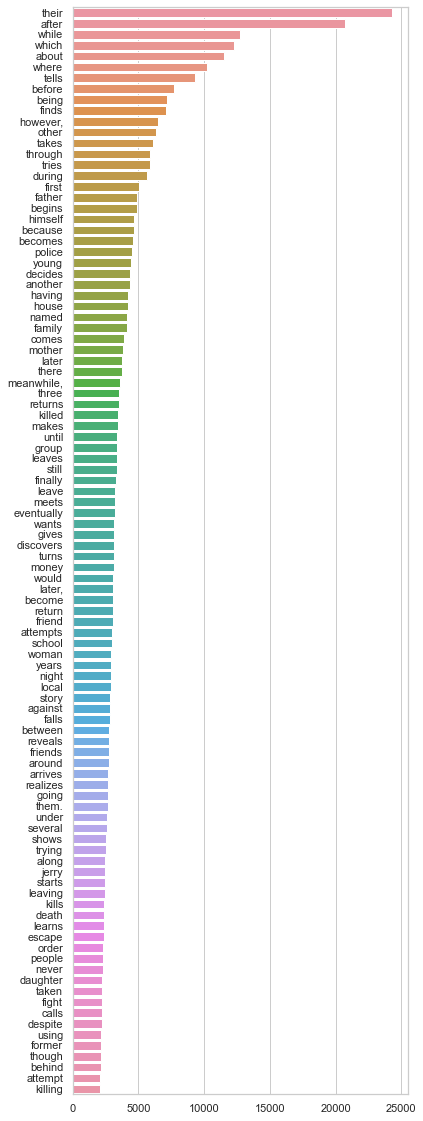

In [95]:
american_separated_words = american_separated_words[:100]
f, ax = plt.subplots(figsize=(6, 20))
sns.barplot(y = american_separated_words.index, x = american_separated_words)